## Step 0. Folder Structure
```
3. Deep Learning Project/
├── dataset_split/
│   ├── train/
│   │   ├── african_elephant (780 images)
│   │   ├── airliner (780 images)
│   │   └── ... (8 more folders)
│   ├── val/
│   │   ├── african_elephant (260 images)
│   │   ├── airliner (260 images)
│   │   └── ... (8 more folders)
│   └── test (2600 images)
├── data_preprocessed/
│   ├── labels_train.pt
│   ├── labels_val.pt
│   ├── tensor_test.pt
│   ├── tensor_train.pt
│   └── tensor_val.pt
├── models/
│   ├── resnet18_checkpoint.pkl
│   └── resnet34_checkpoint.pkl
├── src/
│   └── part3.ipynb
├── src_datasplit/
│   └── data_split.ipynb
├── MSA.yaml
├── README.md
└── IEEE_Report_Template.docx
```


In [1]:
pip install tqdm matplotlib pandas opencv-python scikit-learn numpy


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [52]:
# TODO: Import the libraries.
from typing import Tuple, List
import os
import cv2
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import copy
import matplotlib.pyplot as plt
import csv
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd

## Step 1 Preprocessing
1. Load images and labels from folders into lists.
2. Resize the images.
3. Convert the image data type as float32 and limit the range in [0, 1].
4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.
5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
6. Saving the pre-processed sets as .pt files in the correct directory.
7. Load the pre-processed sets from .pt files. 

In [4]:
# TODO: 1. Load images from folder into a list.
def image_loader(set_dir: str) -> Tuple[List[np.ndarray], List[str]]:
    """
    Load all images from a dataset directory (train/val/test) into memory.
    Make sure:
        1. Load training and validation set images and labels in the correct order.
        2. Load testing set images in filename order (e.g., 0.jpg, 1.jpg, ...).
    
    Parameters:
    -----------
    set_dir : str
        Path to the directory containing either:
        - Class subdirectories (for train/val sets)
        - Direct image files (for test set)
        
    Returns:
    --------
    Tuple[List[np.ndarray], List[str]]
        images: List of BGR images (HWC format, uint8 dtype)
        labels: List of string labels (empty for test set)
        
    Example:
    --------
    >>> images_train, labels_train = image_loader("../dataset_split/train")
    >>> images_test, _ = image_loader("../dataset_split/test")
    """
    
    images = []
    labels = []

    # Check if the directory contains subdirectories (train/val sets)
    class_dirs = sorted([d for d in os.listdir(set_dir) if os.path.isdir(os.path.join(set_dir, d))])
    if class_dirs:
        # Load images from each class subdirectory
        for class_dir in class_dirs:
            class_path = os.path.join(set_dir, class_dir)
            for filename in sorted(os.listdir(class_path)):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_path, filename)
                    image = cv2.imread(img_path)
                    if image is not None:
                        images.append(image)
                        labels.append(class_dir)  # Use the directory name as the label
    else:
        # Load images directly from the directory (test set)
        for filename in sorted(os.listdir(set_dir)):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(set_dir, filename)
                image = cv2.imread(img_path)
                if image is not None:
                    images.append(image)
                    labels.append(filename)  # Use the filename as the label
                
    return images, labels

In [5]:
# TODO: 2. Resize images.
def img_resize(images: List[np.ndarray], target_size: int = 224) -> np.ndarray:
    """
    Resize images with the shortest edge to target_size and perform center cropping to square dimensions.
    
    Args:
        images: List of input images in BGR format (OpenCV default) with shape (H, W, C)
        target_size: Desired output size (both width and height after cropping). Default 224.
        
    Returns:
        Stacked numpy array of processed images with shape (N, target_size, target_size, 3)
        where N is the number of input images
        
    Raises:
        ValueError: If input images have inconsistent channels or invalid dimensions
        
    Notes:
        - Preserves original aspect ratio during resizing
        - Performs center cropping to exact square dimensions
        - Maintains uint8 dtype unless conversion forces float32
        
    Example:
        >>> imgs = [cv2.imread('test.jpg')]  # List of BGR images
        >>> processed = img_resize(imgs)
        >>> processed.shape  # (1, 224, 224, 3)
    """
    if not images:
        return np.array([])

    processed_images = []
    
    for img in images:
        if img is None or len(img.shape) != 3 or img.shape[2] not in [3, 4]:
            raise ValueError("Invalid image shape or number of channels")
        
        # Resize the image while maintaining aspect ratio
        h, w, _ = img.shape
        if h < w:
            new_h = target_size
            new_w = int(w * (target_size / h))
        else:
            new_w = target_size
            new_h = int(h * (target_size / w))
        
        resized_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        
        # Center crop to square dimensions
        start_x = (new_w - target_size) // 2
        start_y = (new_h - target_size) // 2
        cropped_img = resized_img[start_y:start_y + target_size, start_x:start_x + target_size]
        
        cropped_img = cv2.resize(cropped_img, (target_size, target_size), interpolation=cv2.INTER_AREA)
        processed_images.append(cropped_img)

    return np.stack(processed_images)
imgs = [cv2.imread('../dataset_split/test/0.jpg')]  # Load a test image
processed = img_resize(imgs)     # Resize and crop
print(processed.shape)  

(1, 224, 224, 3)


In [6]:
# Load images

images_train, labels_train = image_loader("../dataset_split/train")
images_val, labels_val = image_loader("../dataset_split/val")
images_test, _ = image_loader("../dataset_split/test")

In [7]:
# Resize the images

images_train = img_resize(images_train, 224)
images_val = img_resize(images_val, 224)
images_test = img_resize(images_test, 224)

In [8]:
# TODO: 3. Convert the image data type as float32 and limit the range in [0, 1].

images_train = images_train.astype(np.float32) / 255.0
images_val = images_val.astype(np.float32) / 255.0
images_test = images_test.astype(np.float32) / 255.0

In [9]:
# TODO: 4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.

tensor_train = torch.tensor(images_train.transpose(0, 3, 1, 2)) 
tensor_val = torch.tensor(images_val.transpose(0, 3, 1, 2))    
tensor_test = torch.tensor(images_test.transpose(0, 3, 1, 2)) 

In [10]:
# TODO: 5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).

train_mean = tensor_train.mean(dim=(0, 2, 3), keepdim=True)
train_std = tensor_train.std(dim=(0, 2, 3), keepdim=True)

tensor_train = (tensor_train - train_mean) / train_std
tensor_val = (tensor_val - train_mean) / train_std
tensor_test = (tensor_test - train_mean) / train_std

In [11]:
# TODO: 6. Save the pre-processed sets as .pt files.
os.makedirs("../data_preprocessed", exist_ok=True)

# 6.1 Save the tensor_train, tensor_val, and tensor_test as tensor_train.pt, tensor_val.pt, and tensor_test.pt, respectively.
torch.save(tensor_train, "../data_preprocessed/tensor_train.pt")
torch.save(tensor_val, "../data_preprocessed/tensor_val.pt")
torch.save(tensor_test, "../data_preprocessed/tensor_test.pt")
# 6.2 Create a list to map index to label and a dictionary to map label to index.
#   For instance:
#       unique_labels = ['african_elephant', 'airliner', ...]
#       label_to_index = {
#           'african_elephant': 0,
#           'airliner': 1,
#           ...
#       }
unique_labels = sorted(list(set(labels_train)))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# 6.3 Map the labels to index.
labels_train_index = torch.tensor([label_to_index[label] for label in labels_train])
labels_val_index = torch.tensor([label_to_index[label] for label in labels_val])
torch.save(labels_train_index, "../data_preprocessed/labels_train.pt")
torch.save(labels_val_index, "../data_preprocessed/labels_val.pt")


# 6.4 Save the index, label_to_index, and index_to_label.
torch.save(label_to_index, "../data_preprocessed/label_to_index.pt")
torch.save(index_to_label, "../data_preprocessed/index_to_label.pt")


In [12]:
# TODO: 7. Load the pre-processed sets from .pt files. The data can be used directly in future without pre-processing once more by loading from the folder.

tensor_train = torch.load("../data_preprocessed/tensor_train.pt")
tensor_val = torch.load("../data_preprocessed/tensor_val.pt")
tensor_test = torch.load("../data_preprocessed/tensor_test.pt")

labels_train_index = torch.load("../data_preprocessed/labels_train.pt")
labels_val_index = torch.load("../data_preprocessed/labels_val.pt")

print("Train tensor:", tensor_train.shape)
print("Val tensor:", tensor_val.shape)
print("Test tensor:", tensor_test.shape)
print("Train labels:", labels_train_index.shape)
print("Val labels:", labels_val_index.shape)
print("Number of classes:", len(label_to_index))

Train tensor: torch.Size([7800, 3, 224, 224])
Val tensor: torch.Size([2600, 3, 224, 224])
Test tensor: torch.Size([2600, 3, 224, 224])
Train labels: torch.Size([7800])
Val labels: torch.Size([2600])
Number of classes: 10


# Step 2 Train the teacher model (ResNet34)
1. Set hyperparameters for the training process.
2. Create a pretrained ResNet34.
3. Define the optimizer, loss function, etc.
4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
5. Plot the loss and accuracy curves.

In [13]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [14]:
# TODO: 1. Set hyperparameters for the training process.

MAX_EPOCH = 20
INIT_LR = 0.001
BATCH_SIZE = 64

# Specify the training device (automatically detects GPU if available)
# Usage example: 
#   tensor = tensor.to(device)  # Moves tensor to selected device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# TODO: 2. Create a pretrained ResNet34.

# 2.1 Use torchvision to create a pretrained ResNet34.
resnet34 = models.resnet34(pretrained=True)

# 2.2 Modify the output layer so that the model aligns with this project.
resnet34.fc = nn.Linear(resnet34.fc.in_features, len(label_to_index))
# 2.2 Move the model to selected device.
resnet34 = resnet34.to(device)

print(resnet34)

/Users/sunshuo/Desktop/MSA/MSA_Phase2_2025/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sunshuo/Desktop/MSA/MSA_Phase2_2025/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/sunshuo/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


Python(35181) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 83.3M/83.3M [00:01<00:00, 74.4MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# TODO: 3. Define the optimizer, loss function, etc.

optimizer = optim.Adam(resnet34.parameters(), lr=INIT_LR)
criterion = nn.CrossEntropyLoss()

In [ ]:
# TODO: 4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
# Hint: May not need too many epochs as this is a pretrained model.
train_dataset = TensorDataset(tensor_train, labels_train_index)
val_dataset = TensorDataset(tensor_val, labels_val_index)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_accs_resnet34, train_losses_resnet34, val_accs_resnet34, val_losses_resnet34 = [], [], [], []
best_val_acc = 0.0

for epoch in range(MAX_EPOCH):
    resnet34.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{MAX_EPOCH}"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet34(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate training accuracy and loss
    train_acc = correct / total
    train_losses_resnet34.append(train_loss / total)
    train_accs_resnet34.append(train_acc)
    
    # Validation phase
    resnet34.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet34(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = correct / total
    val_losses_resnet34.append(val_loss / total)
    val_accs_resnet34.append(val_acc)

    print(f"Train Loss: {train_losses_resnet34[-1]:.4f}, Train Acc: {train_accs_resnet34[-1]:.4f}")
    print(f"Val Loss: {val_losses_resnet34[-1]:.4f}, Val Acc: {val_accs_resnet34[-1]:.4f}")

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        os.makedirs("../models", exist_ok=True)
        torch.save(resnet34.state_dict(), "../models/resnet34_checkpoint.pkl")

Epoch 1/20: 100%|██████████| 122/122 [13:38<00:00,  6.71s/it]


Train Loss: 0.5975, Train Acc: 0.8188
Val Loss: 0.5028, Val Acc: 0.8396


Epoch 2/20: 100%|██████████| 122/122 [34:44<00:00, 17.08s/it]  


Train Loss: 0.3323, Train Acc: 0.8971
Val Loss: 0.5501, Val Acc: 0.8469


Epoch 3/20: 100%|██████████| 122/122 [13:57<00:00,  6.86s/it]


Train Loss: 0.2262, Train Acc: 0.9321
Val Loss: 0.4365, Val Acc: 0.8731


Epoch 4/20: 100%|██████████| 122/122 [13:56<00:00,  6.86s/it]


Train Loss: 0.2084, Train Acc: 0.9345
Val Loss: 0.3884, Val Acc: 0.8854


Epoch 5/20: 100%|██████████| 122/122 [14:13<00:00,  6.99s/it]


Train Loss: 0.1601, Train Acc: 0.9495
Val Loss: 0.3307, Val Acc: 0.8981


Epoch 6/20: 100%|██████████| 122/122 [14:13<00:00,  7.00s/it]


Train Loss: 0.1115, Train Acc: 0.9624
Val Loss: 0.3218, Val Acc: 0.8946


Epoch 7/20: 100%|██████████| 122/122 [14:07<00:00,  6.95s/it]


Train Loss: 0.0878, Train Acc: 0.9740
Val Loss: 0.4367, Val Acc: 0.8850


Epoch 8/20: 100%|██████████| 122/122 [14:10<00:00,  6.97s/it]


Train Loss: 0.0987, Train Acc: 0.9681
Val Loss: 0.4500, Val Acc: 0.8758


Epoch 9/20: 100%|██████████| 122/122 [16:35<00:00,  8.16s/it]


Train Loss: 0.0799, Train Acc: 0.9738
Val Loss: 0.3688, Val Acc: 0.9008


Epoch 10/20: 100%|██████████| 122/122 [20:32<00:00, 10.11s/it]


Train Loss: 0.0725, Train Acc: 0.9771
Val Loss: 0.4016, Val Acc: 0.8865


Epoch 11/20: 100%|██████████| 122/122 [21:14<00:00, 10.45s/it]


Train Loss: 0.0742, Train Acc: 0.9763
Val Loss: 0.4024, Val Acc: 0.8877


Epoch 12/20: 100%|██████████| 122/122 [20:43<00:00, 10.19s/it]


Train Loss: 0.0435, Train Acc: 0.9864
Val Loss: 0.4427, Val Acc: 0.8854


Epoch 13/20: 100%|██████████| 122/122 [20:39<00:00, 10.16s/it]


Train Loss: 0.0699, Train Acc: 0.9795
Val Loss: 1.0955, Val Acc: 0.7881


Epoch 14/20: 100%|██████████| 122/122 [20:03<00:00,  9.86s/it]


Train Loss: 0.0580, Train Acc: 0.9822
Val Loss: 0.3676, Val Acc: 0.9035


Epoch 15/20: 100%|██████████| 122/122 [20:00<00:00,  9.84s/it]


Train Loss: 0.0400, Train Acc: 0.9871
Val Loss: 0.3596, Val Acc: 0.9077


Epoch 16/20: 100%|██████████| 122/122 [19:57<00:00,  9.81s/it]


Train Loss: 0.0269, Train Acc: 0.9914
Val Loss: 0.3394, Val Acc: 0.9165


Epoch 17/20: 100%|██████████| 122/122 [19:57<00:00,  9.82s/it]


Train Loss: 0.0412, Train Acc: 0.9878
Val Loss: 0.4246, Val Acc: 0.8950


Epoch 18/20: 100%|██████████| 122/122 [19:58<00:00,  9.83s/it]


Train Loss: 0.0458, Train Acc: 0.9850
Val Loss: 0.4158, Val Acc: 0.8992


Epoch 19/20: 100%|██████████| 122/122 [20:00<00:00,  9.84s/it]


Train Loss: 0.0369, Train Acc: 0.9868
Val Loss: 0.3390, Val Acc: 0.9142


Epoch 20/20: 100%|██████████| 122/122 [19:58<00:00,  9.83s/it]


Train Loss: 0.0439, Train Acc: 0.9859
Val Loss: 0.5435, Val Acc: 0.8765


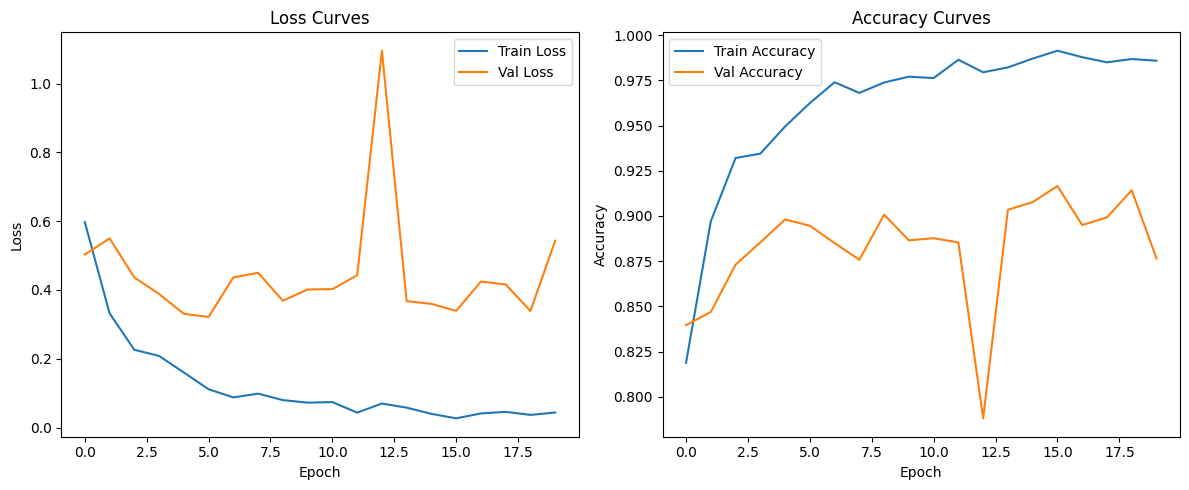

In [25]:
# TODO: 5. Plot the loss and accuracy curves.

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet34, label='Train Loss')
plt.plot(val_losses_resnet34, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs_resnet34, label='Train Accuracy')
plt.plot(val_accs_resnet34, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.show()


# Step 3 Train the student model (ResNet18)
1. Set hyperparameters for the distillation process.
2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
3. Load the saved ResNet34 and move the model to selected device.
4. Define the optimizer, loss function, etc.
5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
6. Plot the loss and accuracy curves.

In [28]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [29]:
# TODO: 1. Set hyperparameters for the distillation process.

MAX_EPOCH = 20
INIT_LR = 0.001
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TEMPERATURE = 4.0
LOSS_RATIO = 0.7

In [30]:
# TODO: 2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.

resnet18 = models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, len(label_to_index))
resnet18 = resnet18.to(device)

In [ ]:
# TODO: 3. Load the saved ResNet34 and move the model to selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet34 = models.resnet34(weights=None)
resnet34.fc = nn.Linear(resnet34.fc.in_features, len(label_to_index))
resnet34.load_state_dict(torch.load("../models/resnet34_checkpoint.pkl", map_location=device))
resnet34.eval()  # Set to evaluation mode
resnet34 = resnet34.to(device)

In [32]:
# TODO: 4. Define the optimizer, loss function, etc.

optimizer = optim.Adam(resnet18.parameters(), lr=INIT_LR)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
# TODO: 5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
# Hint: Use the correct loss function for knowledge distillation.
#       Details can be fund in https://docs.pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html.

train_accs_resnet18, train_losses_resnet18, val_accs_resnet18, val_losses_resnet18 = [], [], [], []
best_val_acc = 0.0

for epoch in range(MAX_EPOCH):
    resnet18.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{MAX_EPOCH}"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Get teacher outputs
        with torch.no_grad():
            teacher_outputs = resnet34(inputs)
        
        # Get student outputs
        student_outputs = resnet18(inputs)
        
        # Compute soft targets and loss
        soft_targets = F.softmax(teacher_outputs / TEMPERATURE, dim=1)
        loss = (1 - LOSS_RATIO) * criterion(student_outputs, labels) + \
               LOSS_RATIO * F.kl_div(F.log_softmax(student_outputs / TEMPERATURE, dim=1), 
                                     soft_targets, reduction='batchmean') * (TEMPERATURE ** 2)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(student_outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate training accuracy and loss
    train_acc = correct / total
    train_losses_resnet18.append(train_loss / total)
    train_accs_resnet18.append(train_acc)
    
    # Validation phase
    resnet18.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = correct / total
    val_losses_resnet18.append(val_loss / total)
    val_accs_resnet18.append(val_acc)

    print(f"Train Loss: {train_losses_resnet18[-1]:.4f}, Train Acc: {train_accs_resnet18[-1]:.4f}")
    print(f"Val Loss: {val_losses_resnet18[-1]:.4f}, Val Acc: {val_accs_resnet18[-1]:.4f}")

    scheduler.step()

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        os.makedirs("../models", exist_ok=True)
        torch.save(resnet18.state_dict(), "../models/resnet18_checkpoint.pkl")

Epoch 1/20: 100%|██████████| 122/122 [12:50<00:00,  6.32s/it]


Train Loss: 7.1550, Train Acc: 0.6671
Val Loss: 3.2416, Val Acc: 0.5058


Epoch 2/20: 100%|██████████| 122/122 [42:43<00:00, 21.01s/it]  


Train Loss: 5.9717, Train Acc: 0.7212
Val Loss: 1.3283, Val Acc: 0.7400


Epoch 3/20: 100%|██████████| 122/122 [18:44<00:00,  9.22s/it]


Train Loss: 4.9630, Train Acc: 0.7665
Val Loss: 2.0293, Val Acc: 0.6765


Epoch 4/20: 100%|██████████| 122/122 [19:32<00:00,  9.61s/it]


Train Loss: 4.3782, Train Acc: 0.7904
Val Loss: 1.6378, Val Acc: 0.7250


Epoch 5/20: 100%|██████████| 122/122 [19:34<00:00,  9.63s/it]


Train Loss: 3.3297, Train Acc: 0.8423
Val Loss: 0.7761, Val Acc: 0.8350


Epoch 6/20: 100%|██████████| 122/122 [19:28<00:00,  9.58s/it]


Train Loss: 2.9331, Train Acc: 0.8608
Val Loss: 0.7593, Val Acc: 0.8446


Epoch 7/20: 100%|██████████| 122/122 [19:39<00:00,  9.67s/it]


Train Loss: 2.7584, Train Acc: 0.8686
Val Loss: 0.7699, Val Acc: 0.8450


Epoch 8/20: 100%|██████████| 122/122 [19:30<00:00,  9.59s/it]


Train Loss: 2.6405, Train Acc: 0.8772
Val Loss: 0.7655, Val Acc: 0.8438


Epoch 9/20: 100%|██████████| 122/122 [19:32<00:00,  9.61s/it]


Train Loss: 2.5208, Train Acc: 0.8846
Val Loss: 0.7812, Val Acc: 0.8450


Epoch 10/20: 100%|██████████| 122/122 [19:29<00:00,  9.59s/it]


Train Loss: 2.3390, Train Acc: 0.8903
Val Loss: 0.7197, Val Acc: 0.8554


Epoch 11/20: 100%|██████████| 122/122 [19:30<00:00,  9.59s/it]


Train Loss: 2.2852, Train Acc: 0.8968
Val Loss: 0.7109, Val Acc: 0.8558


Epoch 12/20: 100%|██████████| 122/122 [19:33<00:00,  9.62s/it]


Train Loss: 2.2570, Train Acc: 0.8944
Val Loss: 0.7018, Val Acc: 0.8573


Epoch 13/20: 100%|██████████| 122/122 [19:32<00:00,  9.61s/it]


Train Loss: 2.2353, Train Acc: 0.8969
Val Loss: 0.6973, Val Acc: 0.8565


Epoch 14/20: 100%|██████████| 122/122 [19:32<00:00,  9.61s/it]


Train Loss: 2.2402, Train Acc: 0.8986
Val Loss: 0.6987, Val Acc: 0.8550


Epoch 15/20: 100%|██████████| 122/122 [19:30<00:00,  9.60s/it]


Train Loss: 2.2610, Train Acc: 0.8992
Val Loss: 0.6971, Val Acc: 0.8554


Epoch 16/20: 100%|██████████| 122/122 [19:29<00:00,  9.59s/it]


Train Loss: 2.2292, Train Acc: 0.8986
Val Loss: 0.7016, Val Acc: 0.8581


Epoch 17/20: 100%|██████████| 122/122 [19:30<00:00,  9.60s/it]


Train Loss: 2.1977, Train Acc: 0.8978
Val Loss: 0.7038, Val Acc: 0.8573


Epoch 18/20: 100%|██████████| 122/122 [19:35<00:00,  9.63s/it]


Train Loss: 2.1950, Train Acc: 0.9001
Val Loss: 0.6902, Val Acc: 0.8550


Epoch 19/20: 100%|██████████| 122/122 [19:32<00:00,  9.61s/it]


Train Loss: 2.2134, Train Acc: 0.8977
Val Loss: 0.7124, Val Acc: 0.8588


Epoch 20/20: 100%|██████████| 122/122 [19:27<00:00,  9.57s/it]


Train Loss: 2.2141, Train Acc: 0.8997
Val Loss: 0.7005, Val Acc: 0.8554


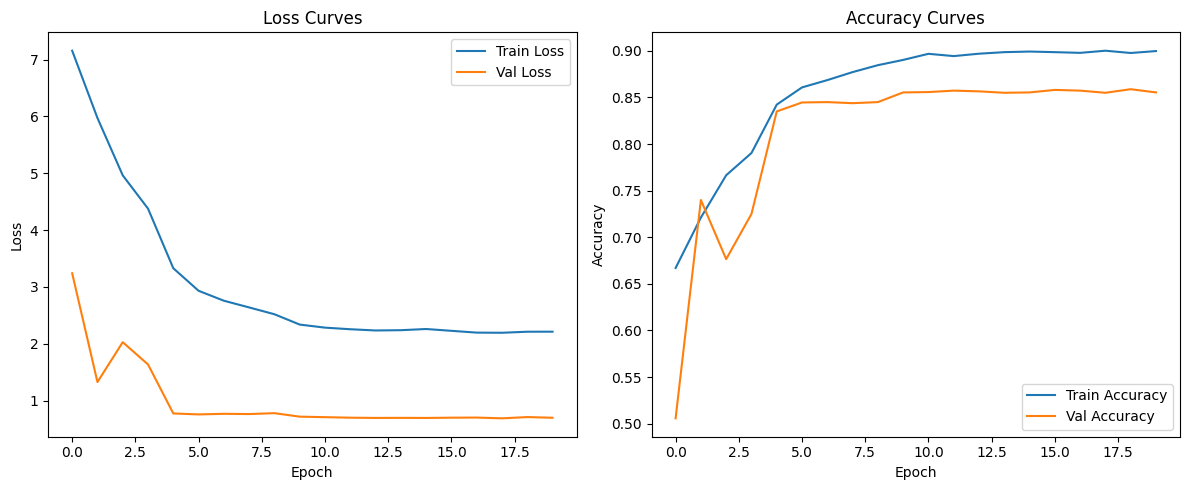

In [66]:
# TODO: 6. Plot the loss and accuracy curves.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet18, label='Train Loss')
plt.plot(val_losses_resnet18, label='Val Loss') 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()    

plt.subplot(1, 2, 2)
plt.plot(train_accs_resnet18, label='Train Accuracy')
plt.plot(val_accs_resnet18, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.show()



# Step 4 Predict labels in the testing set
1. Load the saved ResNet18 and move it to the selected device.
2. Do prediction using the images in the testing set.
3. Write the results into the CSV file for submission.

In [ ]:
# TODO: 1. Load the saved ResNet18 and move it to the selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet18 = models.resnet18(weights=None)
resnet18.fc = nn.Linear(resnet18.fc.in_features, len(label_to_index))
resnet18.load_state_dict(torch.load("../models/resnet18_checkpoint.pkl", map_location=device))

resnet18 = resnet18.to(device)
resnet18.eval()  # Set to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [95]:
# TODO: 2. Do prediction using the images in the testing set.
predictions = []

with torch.no_grad():
    for inputs in range(tensor_test.shape[0]):
        images = tensor_test[inputs].unsqueeze(0).to(device)  # Add batch dimension
        outputs = resnet18(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

KeyboardInterrupt: 

In [80]:
# TODO: 3. Write the results into the CSV file for submission.
# Hint: The CSV file should be in the format of 'file_name' and 'label'.
#       The submission.csv should look like:
#           file_name,label
#           0.jpg,sunglasses
#           ...

index_to_label = torch.load("../data_preprocessed/index_to_label.pt")

submission = []
for i, pred in enumerate(predictions):
    
    label = index_to_label[pred]
    file_name = f"{i}.jpg"
    submission.append({"file_name":file_name, "label":label})

df = pd.DataFrame(submission)
df.to_csv("submission.csv", index=False)


In [98]:
print(index_to_label)
print(predictions[:20])  # Print first 10 predictions for verification

{0: 'african_elephant', 1: 'airliner', 2: 'banana', 3: 'convertible_car', 4: 'golden_retriever', 5: 'goldfish', 6: 'parachute', 7: 'rugby', 8: 'sunglasses', 9: 'tiger_cat'}
[np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(5)]
